In [1]:
!wget -O zen_dataset.tar.gz https://www.dropbox.com/s/5ugsinj434yzmu6/zen_dataset.tar.gz?dl=0
!tar -xzvf zen_dataset.tar.gz

SyntaxError: invalid decimal literal (2311644270.py, line 1)

In [1]:
!pip install catboost


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


# Ранжирующая модель

Классический пайплайн рекомендаций выглядит следующим образом:

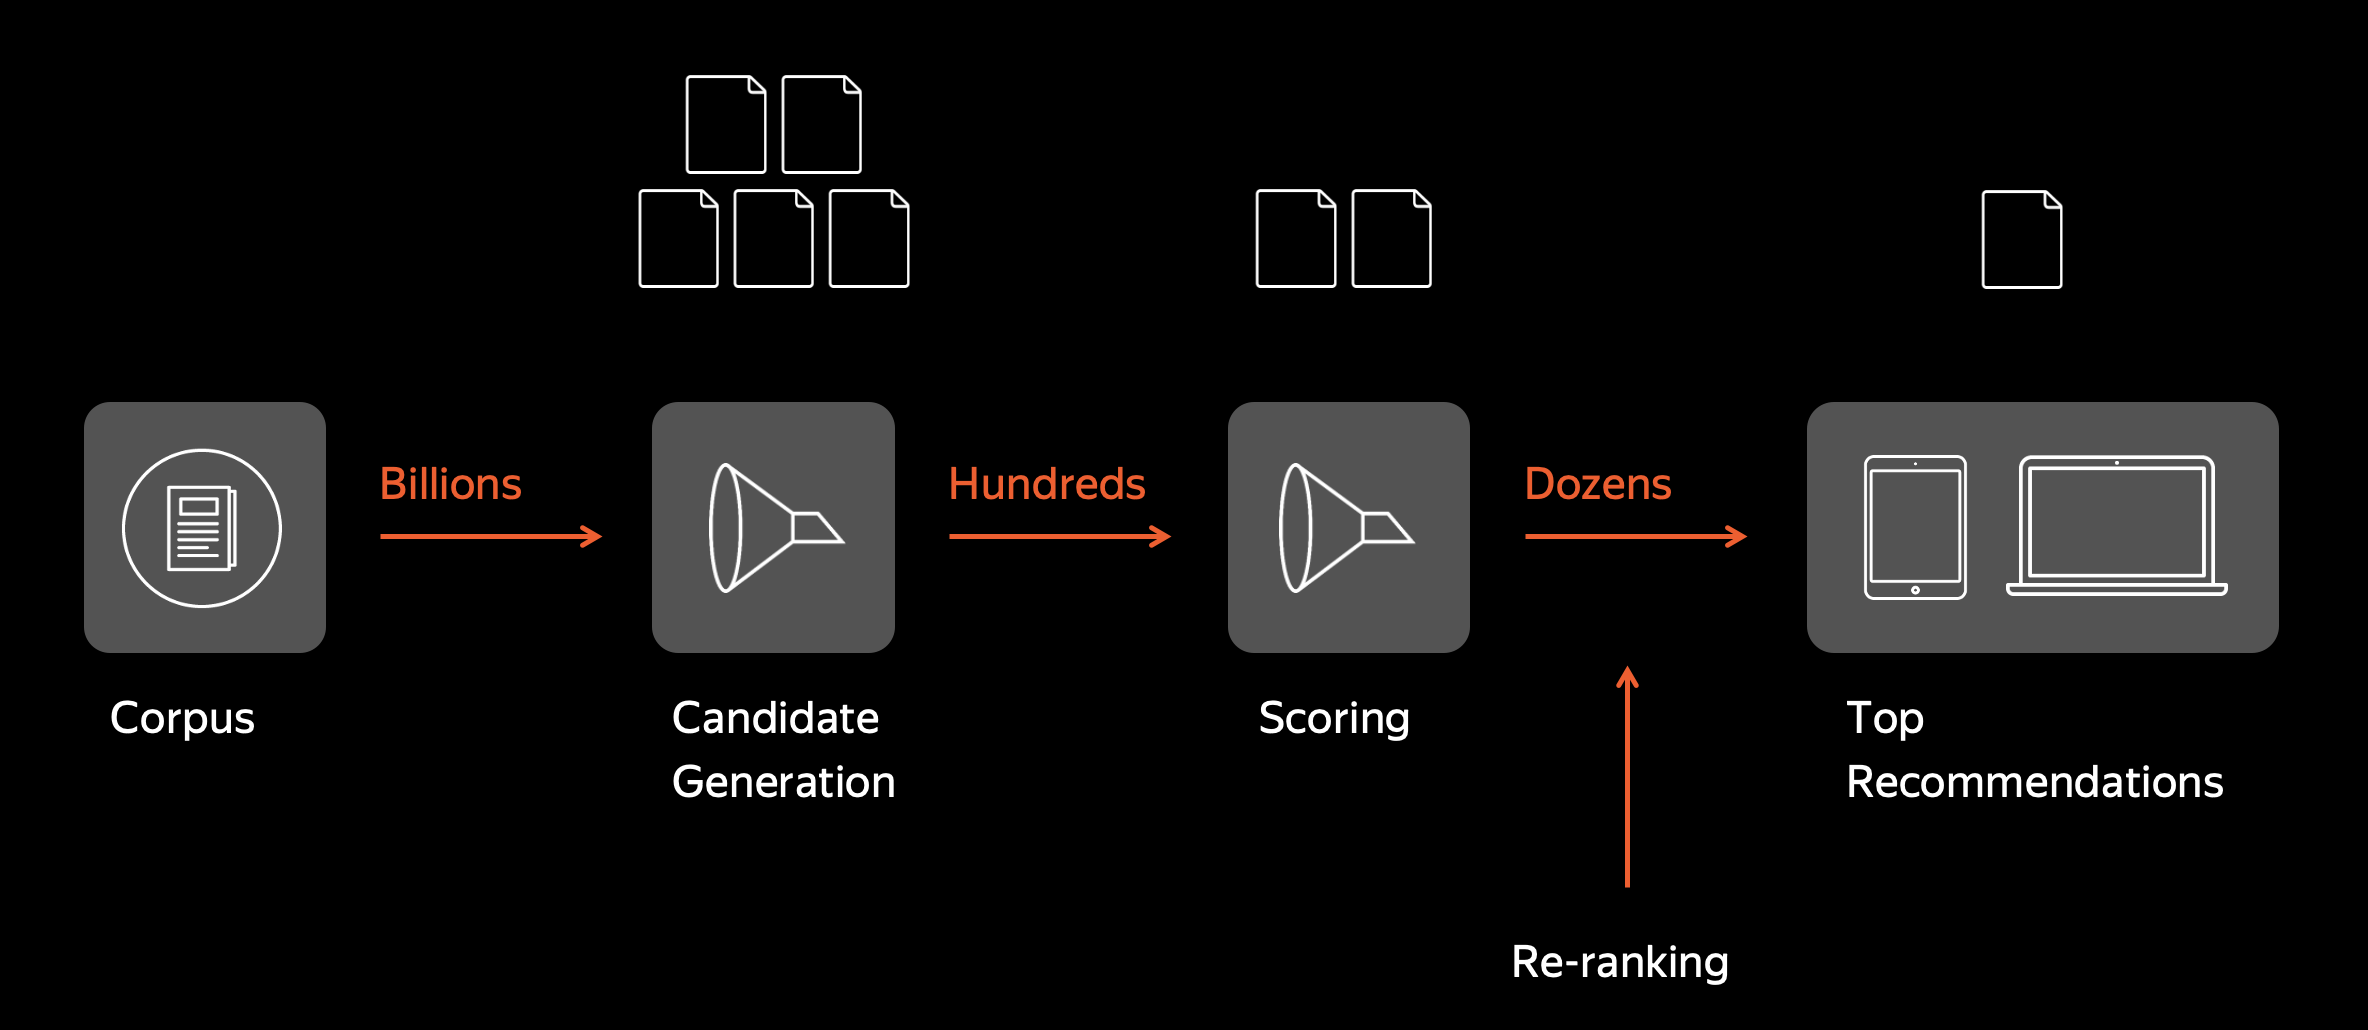

* Отбор кандидатов. Сначала из всей базы документов отбирается некоторое количество кандидатов. Это нужно, потому что в реальном сервисе очень большое количество документов и невозможно на каждый запрос отскорить всё. В качестве "селекторов" могут выступать простые с вычислительной точки зрения модели (например, kNN по эмбеддингам, предсказание FM, SLIM).
* Ранжирующая модель. Отобранные на предыдущем шаге айтемы ранжируются моделью, чтобы отобрать топ документов для пользователя.
* Затем айтемы дополнительно переранжируются с учетом бизнес-логики.

Более подробно этот пайплайн обсуждался на лекции 1.

В этом задании вам предстоит построить и обучить ранжирующую модель на датасете Дзена.

В качестве самой модели применяют модели на основе градиентного бустинга, в данном задании предлагается использовать CatBoost. В качестве фичей модели используем
* Скалярное произведение, косинусное расстояние между пользовательским и айтемным эмбеддингами. Эмбеддинги: *explicit ALS*, *implicit ALS*, обученные в прошлом задании, контентные модели.
* Айтемные и пользовательские статистики (ctr, количество показов и т.п.)

In [2]:
import numpy as np
import pandas as pd

import tqdm
import json
import itertools
import collections

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

sns.set()

In [3]:
item_counts = pd.read_csv('zen_dataset/item_counts.csv', index_col=0)
item_meta = pd.read_csv('zen_dataset/item_meta.gz', compression='gzip', index_col=0)
user_ratings = pd.read_csv('zen_dataset/user_ratings.gz', compression='gzip', index_col=0)

In [5]:
item_counts['itemId'] = item_counts['itemId'].apply(str)
item_meta['itemId'] = item_meta['itemId'].apply(str)

In [35]:
def parse_ratings_history(string):
    return json.loads(string.replace("'", '"'))

In [6]:
user_encoder = LabelEncoder().fit(user_ratings['userId'])
item_encoder = LabelEncoder().fit(item_counts['itemId'])

all_items = item_counts['itemId']
item_indices = item_encoder.transform(all_items)
item_to_id = dict(zip(all_items, item_indices))

In [55]:
all_users = user_ratings['userId']
user_indices = user_encoder.transform(all_users)
user_to_id = dict(zip(all_users, user_indices))

In [25]:
item_meta

,itemId,title,content,combined_text
0,5480844460835530524,"Нехитрые способы, как самостоятельно проверить...","С раннего детства нам рассказывают, что сама...","Нехитрые способы, как самостоятельно проверить..."
1,25708764690236829,Где находилась сверхсекретная база подводных л...,"Сомневаюсь, что найдётся сейчас человек, котор...",Где находилась сверхсекретная база подводных л...
2,25995859650472943,Тапки ( жуткий рассказ),Год назад эту историю рассказала мне моя родс...,Тапки ( жуткий рассказ) Год назад эту историю...
3,26039067597386753,Крутые находки на Aliexpress №1113,"Доброго времени суток, Уважаемые читатели! Доб...",Крутые находки на Aliexpress №1113 Доброго вре...
4,26225874317634871,Нам пообещали высокую инфляцию. Деньги сильно ...,Цены в магазинах и темпы инфляции растут не то...,Нам пообещали высокую инфляцию. Деньги сильно ...
...,...,...,...,...
104498,6221825086402198588,Сколько можно заработать на видеокартах с AGP ...,"Очень старые видеокарты с интерфейсом AGP, кот...",Сколько можно заработать на видеокартах с AGP ...
104499,6221897338759013055,Укрытие Роз на зиму,По Вашим просьбам - повторяю пост прошлого год...,Укрытие Роз на зиму По Вашим просьбам - повтор...
104500,6221960724554910431,"Мама, мамочка, мамуля: снимки самого близкого ...",В подборке снимков из нашего архива — фотограф...,"Мама, мамочка, мамуля: снимки самого близкого ..."
104501,6222047264920702976,Что лучше: сдавать наследственную квартиру или...,"""Кварта − новый бренд ПИК-Брокер"" Привет, меня...",Что лучше: сдавать наследственную квартиру или...


In [46]:
user_ratings

,userId,trainRatings,testRatings
0,-993675863667353526,"{'-5222866277752422391': 0, '-9060464686933784...","{'-2554466548053893601': 0, '-2220576615613681..."
1,-4250619547882954185,"{'-4553947455665416667': 0, '-3876917199970727...","{'-3523829386334236920': 0, '-1723368694207177..."
2,-3847785305345691076,"{'1455441194337562599': 0, '-17536433251064509...","{'1148168316930968740': 0, '706941777097091385..."
3,1785181112918558233,"{'-2853304815794005643': 0, '-8508657381620121...","{'4719491585277936855': 1, '706941777097091385..."
4,-5078748097863903181,"{'-742528302744844176': 1, '-82389094081541106...","{'6294770073358764390': 0, '-40435255593741244..."
...,...,...,...
75905,4954138831959898373,"{'-6764562552262937310': 0, '-7209088773475894...","{'-1685266709911581206': 0, '-5318736529174157..."
75906,4967793435819938014,"{'6602646631687202064': 0, '-38704649420060130...","{'6266145763213971476': 0, '-37217722565891246..."
75907,-7137764184903122777,"{'-7841343107825813783': 0, '-6743959661482653...","{'482864988385991583': 1, '-132806041087172535..."
75908,-2624987805086334956,"{'-8048759438586949657': 0, '-7609637705975070...","{'-5614425467424704155': 0, '62661457632139714..."


In [45]:
item_to_id

{'2260449285691840072': 60017,
 '-8961093042137696748': 49991,
 '-767028345530903101': 41865,
 '4123700977569815347': 71921,
 '992305795279709612': 104463,
 '1834860733252360511': 57262,
 '-3169260100213302766': 13542,
 '6257341665979578135': 85548,
 '-6696326524107237343': 35748,
 '-2804139083268082575': 11261,
 '4458355878827095479': 74059,
 '2566877130360538483': 61919,
 '1917298282597758814': 57846,
 '-7741337029588977132': 42282,
 '4526832577525638176': 74522,
 '-7538463560532528205': 41106,
 '1635227885606818850': 56042,
 '-5562796636693068423': 28615,
 '1897930483633208292': 57702,
 '-8969392676802303423': 50050,
 '1671392159575150039': 56280,
 '3124835814070251061': 65512,
 '7367930623847216988': 92541,
 '3691142168130108512': 69142,
 '8578408429386316534': 100007,
 '1052807535611095123': 52446,
 '-2864145094965641060': 11658,
 '3788168674044752175': 69761,
 '6994220872145181845': 90196,
 '6751242164615561667': 88679,
 '-60615137820477312': 31775,
 '-1329860704125058323': 2096,

## ALS (10 points)

Обучите explicit и implicit ALS.

In [ ]:
DIMENSION = 10

In [7]:
import numpy as np
from scipy.sparse import csr_matrix
import implicit

def compute_als_embedding(user_items, item_factors, user_id, regularizer=0.1, factors=10, iterations=1):
    """
    Обновить эмбеддинг пользователя, используя ALS из библиотеки implicit.

    Аргументы:
    user_items -- матрица взаимодействия пользователей и айтемов в формате CSR
    item_factors -- матрица факторов айтемов из предыдущей тренировки ALS модели
    user_id -- ID пользователя для которого нужно обновить эмбеддинг
    regularizer -- коэффициент L2-регуляризации
    factors -- количество факторов в ALS модели
    iterations -- количество итераций обучения ALS

    Возвращает:
    updated_user_embedding -- обновленный вектор пользователя
    """
    # Инициализация модели ALS
    implicit.approximate_als
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=regularizer, iterations=iterations, calculate_training_loss=True, use_gpu=True)

    # Применение предобученных факторов айтемов к модели
    model.item_factors = item_factors

    # Обучение модели ALS с фиксированными факторами айтемов
    model.fit(user_items.T, show_progress=False)

    # Получение обновленного эмбеддинга для указанного пользователя
    updated_user_embedding = model.user_factors[user_id]

    return updated_user_embedding

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.6/761.6 kB 3.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
def compute_eals_embedding(embeddings, indices, ratings, regularizer=0.1):
    """
    (можно в описании везде поменять местами "пользователей" и "айтемы")
    Обновить ALS эмбеддинг пользователя по эмбеддингам айтемов

    * embeddings -- айтемные эмбеддинги
    * indices -- индексы айтемов, с которыми взаимодействовал пользователь
    * ratings -- оставленные им рейтинги
    * regularizer -- коэффициент L2-регуляризации

    Возвращает новый эмбеддинг пользователя
    """

    ...

    return updated_embedding


def compute_ials_embedding(yty, embeddings, indices, weights, ratings, regularizer=0.1):
    """
    (можно в описании везде поменять местами "пользователей" и "айтемы")
    Обновить iALS эмбеддинг пользователя по эмбеддингам айтемов

    * yty -- матрица Y^T Y по айтемным эмбеддингам
    * embeddings -- айтемные эмбеддинги
    * indices -- индексы айтемов, с которыми взаимодействовал пользователь
    * weights -- веса айтемов в лоссе
    * ratings -- оставленные им рейтинги
    * regularizer -- коэффициент L2-регуляризации

    Возвращает новый эмбеддинг пользователя
    """

    ...

    return updated_embedding


def train_eals(data, dimension=DIMENSION, steps=10):
    """
    data -- данные в созданном вами формате
    """
    item_embeddings = np.random.randn(n_items, dimension)
    for _ in tqdm.notebook.tqdm(range(steps)):
        user_embeddings = ...  # Шаг eALS из айтемных эмбеддингов
        item_embeddings = ...  # Шаг eALS из пользовательских эмбеддингов
    return user_embeddings, item_embeddings


def train_ials(data, dimension=DIMENSION, steps=10, alpha=10):
    item_embeddings = np.random.randn(n_items, dimension)
    for _ in tqdm.notebook.tqdm(range(steps)):
        user_embeddings = ...  # Шаг iALS из айтемных эмбеддингов
        item_embeddings = ...  # Шаг iALS из пользовательских эмбеддингов
    return user_embeddings, item_embeddings

In [ ]:
eals_user_embeddings, eals_item_embeddings = ...

In [ ]:
ials_user_embeddings, ials_item_embeddings = ...

## Контентная модель (5 points)

Выберите модель по своему усмотрению и посчитайте эмбединги айтемов для них.

Какую размерность эмбедингов вы хотите взять? Почему?

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer


item_meta.fillna('', inplace=True)
item_meta['combined_text'] = item_meta['title'] + " " + item_meta['content']

vectorizer = TfidfVectorizer(max_features=100)
tfidf_matrix = vectorizer.fit_transform(item_meta['combined_text'])
content_item_embeddings = tfidf_matrix.toarray()
print("Размерность эмбеддинга:", content_item_embeddings.shape)

Размерность эмбеддинга: (104503, 100)


In [19]:
content_item_embeddings

array([[0.10801783, 0.        , 0.        , ..., 0.07202906, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.16287538, 0.        ,
        0.05628205],
       [0.        , 0.        , 0.04062731, ..., 0.        , 0.0194351 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15154349, 0.        , 0.06059644, ..., 0.        , 0.08696349,
        0.        ],
       [0.01880211, 0.05958296, 0.        , ..., 0.05641978, 0.        ,
        0.        ]])

### АЛС шаг от контентной модели (5 points)

Для того чтобы учесть контентные связи между айтемами (важно в случае небольшого количества статистики на айтеме или пользователе), но при этом иметь эмбеды пользователей, можно сделать один шаг АЛС (вычисление пользовательских эмбедов). Далее их нужно будет использовать в финальном ранжировании.

In [26]:
user_ratings

,userId,trainRatings,testRatings
0,-993675863667353526,"{'-5222866277752422391': 0, '-9060464686933784...","{'-2554466548053893601': 0, '-2220576615613681..."
1,-4250619547882954185,"{'-4553947455665416667': 0, '-3876917199970727...","{'-3523829386334236920': 0, '-1723368694207177..."
2,-3847785305345691076,"{'1455441194337562599': 0, '-17536433251064509...","{'1148168316930968740': 0, '706941777097091385..."
3,1785181112918558233,"{'-2853304815794005643': 0, '-8508657381620121...","{'4719491585277936855': 1, '706941777097091385..."
4,-5078748097863903181,"{'-742528302744844176': 1, '-82389094081541106...","{'6294770073358764390': 0, '-40435255593741244..."
...,...,...,...
75905,4954138831959898373,"{'-6764562552262937310': 0, '-7209088773475894...","{'-1685266709911581206': 0, '-5318736529174157..."
75906,4967793435819938014,"{'6602646631687202064': 0, '-38704649420060130...","{'6266145763213971476': 0, '-37217722565891246..."
75907,-7137764184903122777,"{'-7841343107825813783': 0, '-6743959661482653...","{'482864988385991583': 1, '-132806041087172535..."
75908,-2624987805086334956,"{'-8048759438586949657': 0, '-7609637705975070...","{'-5614425467424704155': 0, '62661457632139714..."


In [58]:
rows = []
for i in user_ratings.index:
    user_id = user_to_id[user_ratings.at[i, 'userId']]
    ratings = parse_ratings_history(user_ratings.at[i, 'trainRatings'])
    for item_id, rating in ratings.items():
        rows.append({'userId': user_id, 'itemId': item_to_id[item_id], 'rating': rating})

ratings_df = pd.DataFrame(rows)
ratings_df

,userId,itemId,rating
0,33745,26350,0
1,33745,50647,0
2,33745,70824,0
3,33745,95984,0
4,33745,43613,0
...,...,...,...
42185498,54593,42542,1
42185499,54593,52037,0
42185500,54593,95071,1
42185501,54593,9850,0


In [59]:
from scipy.sparse import csr_matrix
# Получение количества уникальных пользователей и айтемов
n_users = ratings_df['userId'].nunique()
n_items = ratings_df['itemId'].nunique()

# Необходимо правильно определить максимальные ID, если они не начинаются с 0
max_item_id = int(ratings_df['itemId'].max()) + 1

# Создание разреженной матрицы
user_item_matrix = csr_matrix((ratings_df['rating'], (ratings_df['userId'], ratings_df['itemId'])), shape=(n_users, max_item_id))
user_item_matrix

<75910x104503 sparse matrix of type '<class 'numpy.int64'>'
	with 42185503 stored elements in Compressed Sparse Row format>

In [62]:
from implicit.als import AlternatingLeastSquares

model = AlternatingLeastSquares(factors=100, iterations=1, calculate_training_loss=True)
# factors - размерность должна соответствовать размеру эмбеддингов айтемов из TF-IDF

# Инициализация модели с использованием контентных эмбеддингов айтемов
model.item_factors = content_item_embeddings

# Фиксируем факторы айтемов и выполняем один шаг ALS, чтобы вычислить факторы пользователей
# Для этого можно модифицировать исходный код implicit ALS или использовать user_item связи для дополнительной тонкой настройки

model.fit(user_item_matrix.T, show_progress=True)

content_user_embeddings = model.user_factors
content_user_embeddings

/Users/tyapkinpetr/PycharmProjects/recsys_v1/venv/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.27816200256347656 seconds
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

## Catboost (10 points)

Построим эмбеддинговые признаки пары пользователь-айтем.

In [ ]:
class EmbeddingFeatureGetter:
    def __init__(self, user_embeddings, item_embeddings):
        self.user_embeddings = user_embeddings
        self.item_embeddings = item_embeddings

    def get_features(self, user_id, item_ids):
        """
        * user_id -- индекс пользователя для построения признаков
        * item_ids -- список индексов айтемов
        """
        ...

        return dot, cos

In [ ]:
eals_features_getter = EmbeddingFeatureGetter(eals_user_embeddings, eals_item_embeddings)
ials_features_getter = EmbeddingFeatureGetter(ials_user_embeddings, ials_item_embeddings)
content_features_getter = EmbeddingFeatureGetter(content_user_embeddings, dssm_item_embeddings)

Построим айтемные и пользовательские признаки.

In [ ]:
item_features = [...]

In [ ]:
user_features = [...]

Для построения модели catboost будем пользоваться одноименной [библиотекой](https://catboost.ai/en/docs/concepts/python-reference_catboost). Для обучения модели удобно использовать интерфейс библиотеки, с использованием представления данных `Pool`.

In [ ]:
import catboost

In [ ]:
train_features = ...
train_labels = [...]
train_group_ids = [...]

In [ ]:
train_pool = catboost.Pool(train_features, train_labels, group_id=train_group_ids)

In [ ]:
test_features = ...
test_labels = [...]
test_group_ids = [...]

In [ ]:
test_pool = catboost.Pool(test_features, test_labels, group_id=test_group_ids)

Обучим саму модель. В [документации](https://catboost.ai/en/docs/references/training-parameters/common#loss_function) есть описание того, как передавать лосс, и какие функции возможны.

Попробуйте обучить на лосс бинарной классификации и ранжирования (второе стоит учить с маленьким числом генерируемых пар на `group_id` во избежание вычислительных трудностей).

In [ ]:
cb = catboost.CatBoost({...})

In [ ]:
cb.fit(train_pool, eval_set=test_pool)

Оценим качество

In [ ]:
per_user_predictions = [...]  # user -> predictions

In [ ]:
def calculate_per_user_auc(user_ratings, per_user_predictions):
    pass

In [ ]:
per_user_auc = calculate_per_user_auc(user_ratings, per_user_predictions)
print(np.mean(per_user_auc))

**Выводы:**
\<YOUR CONCLUSIONS\>